<h3>1. Import Required Libraries</h3>

In [38]:

import tensorflow as tf       # main library for deep learning
from tensorflow.keras.models import Sequential  # to add layers one after the other
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Conv2D: A convolutional layer that extracts features from the images.
# MaxPooling2D: A pooling layer that reduces the size of the image to focus on the most important parts.
# Flatten: Converts 2D data into a 1D format to connect to dense layers.
# Dense: A fully connected layer, which is standard in neural networks.

from tensorflow.keras.models import load_model
# load_model: Loads a pre-trained model from a file, allowing you to reuse saved models.

from tensorflow.keras.utils import img_to_array, load_img  
# img_to_array, load_img: Functions that help load and convert images into a format the model can work with.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# useful tool for image preprocessing and augmentation (creating slight variations in images to improve model performance).

# NumPy for numerical data manipulation
import numpy as np 
# A powerful library for handling arrays and matrices, making it essential for tasks like managing and transforming image data in machine learning.

# OS for file management and handling directories
import os
# A standard library for interacting with the operating system, like creating directories, navigating file paths, and managing files.

# for showing data
import matplotlib.pyplot as plt 

<h3>2. Preparing Dataset</h3>

In [39]:
# Define the base dataset directory
base_dir = 'data_sets'
organ_names = ['heart','brain' , 'liver', 'limbs']  # list contating 4 organs names

data_paths = {organ: os.path.join(base_dir, organ) for organ in organ_names} # to creat data paths in data sets for each organ 

# Check the number of images in each organ's directory
for organ in organ_names:
    path = data_paths[organ]
    if os.path.exists(path):
        num_images = len([f for f in os.listdir(path) if f.lower().endswith('.jpg')])
        print(f"{organ.capitalize()}: {num_images} images")
    else:
        print(f"Warning: Directory {path} does not exist")


Heart: 942 images
Brain: 1219 images
Liver: 617 images
Limbs: 1987 images


<h3>3. Load Data</h3>

In [40]:
# Load the dataset with image validation
data = tf.keras.utils.image_dataset_from_directory(     # loads images directly from the specified folder and organizes them for model training. 
    'data_sets',
    labels='inferred', # This infers labels automatically based on folder names so each organ’s folder will be assigned a corresponding label.
    label_mode='categorical', # This sets the labels in a "one-hot" encoded format (a format for multi-class classification where each label is represented as a binary vector, like [1, 0, 0, 0] for heart, etc.).
    batch_size=4, # Loads 32 images per batch for training, which helps optimize memory usage.
    image_size=(256, 256), # Resizes all images to 256x256 pixels, which standardizes the input size for the model.
    shuffle=True # Randomly shuffles the images, ensuring the model sees varied data in each batch.
)

# Create an iterator to fetch batches until all labels are present
data_iterator = data.as_numpy_iterator() # convert data into numpy iterator
expected_labels = {0, 1, 2, 3}

while True:
    batch = data_iterator.next()
    
    # Convert the one-hot encoded labels to their class indices
    labels_in_batch = set([np.argmax(label) for label in batch[1]]) # convert form [1, 0, 0, 0] to (0, 1, 2, or 3)
    
    if expected_labels.issubset(labels_in_batch):
        print("Labels in batch:", labels_in_batch)
        break
batch[1]  # show lables for each organ

Found 4765 files belonging to 4 classes.
Labels in batch: {0, 1, 2, 3}


array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

<h3>4. Show Data</h3>

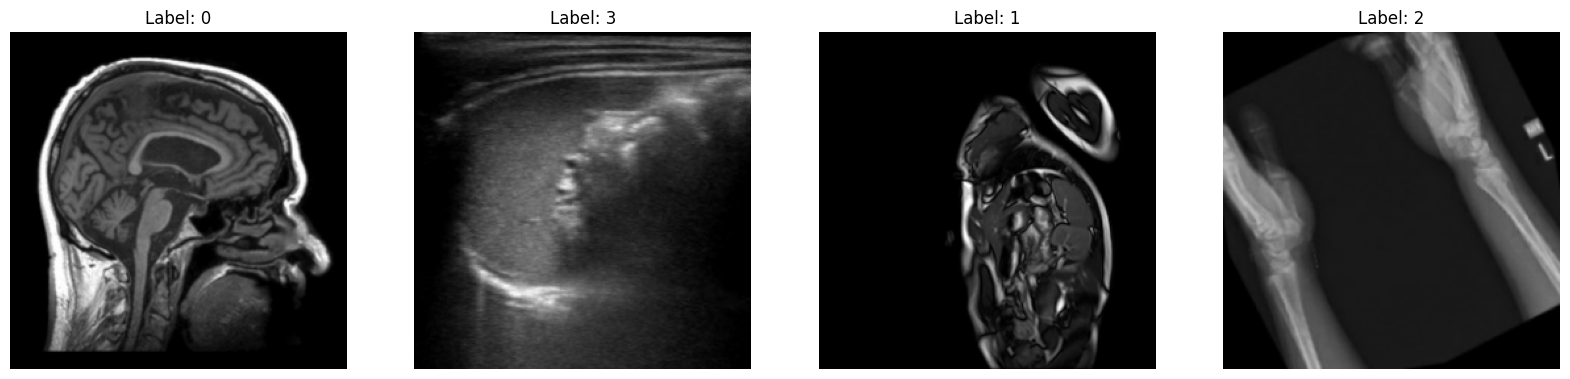

In [41]:
# Define the labels you want to display
labels_to_show = [0, 1, 2, 3]
found_labels = {label: False for label in labels_to_show}  # Track found labels
indices_to_show = []

# Go through each one-hot encoded label in the batch to find the first occurrence of each label
for idx, label in enumerate(batch[1]):
    class_index = np.argmax(label)  # Get the class index from the one-hot encoded label
    if class_index in labels_to_show and not found_labels[class_index]: # Checks if the class is one you want to display and if it hasn’t been found yet.
        indices_to_show.append(idx)
        found_labels[class_index] = True  # Mark label as found
    if all(found_labels.values()):  # Stop once we have all labels
        break

# Create subplots for each label
fig, ax = plt.subplots(ncols=len(indices_to_show), figsize=(20, 20))

# Display the images and their corresponding labels
for i, idx in enumerate(indices_to_show):
    ax[i].imshow(batch[0][idx].astype(int))
    ax[i].title.set_text(f'Label: {np.argmax(batch[1][idx])}')  # Show the label index
    ax[i].axis('off')  # Optional: Hide axes for a cleaner look

plt.show()

<h3>5. Scaling Data</h3>

In [42]:
# Data scaling and optimization
data = data.map(lambda x, y: (x / 255, y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

<h3>6. Split Data</h3>

In [92]:
# Split the dataset
train_size = int(len(data) * 0.3) + 1
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

test

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

<h3>7. Creating Model</h3>

In [62]:

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Dropout(0.3),  # High dropout rate
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(len(organ_names), activation='softmax')
])

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │     4,129,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,129,964 (15.75 MB)

 Trainable params: 4,129,964 (15.75 MB)

 Non-trainable params: 0 (0.00 B)

<h3>8. Train Model</h3>

In [63]:
# Set up logging for TensorBoard
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model with error handling
try:
    history = model.fit(
        train,
        validation_data=val,
        epochs=5,
        callbacks=[tensorboard_callback]
    )
except InvalidArgumentError as e:
    print("Training interrupted due to an error:", e)
    print("Please check the dataset for corrupted or unreadable images.")

Epoch 1/5


358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.6506 - loss: 1.1606 - val_accuracy: 0.7563 - val_loss: 0.5285
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.8093 - loss: 0.4009 - val_accuracy: 0.7950 - val_loss: 0.4468
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8364 - loss: 0.3396 - val_accuracy: 0.8546 - val_loss: 0.4562
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.8459 - loss: 0.2974 - val_accuracy: 0.8818 - val_loss: 0.3777
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9040 - loss: 0.2613 - val_accuracy: 0.8462 - val_loss: 0.3651


<h3>9. Model Performance Gragh</h3>

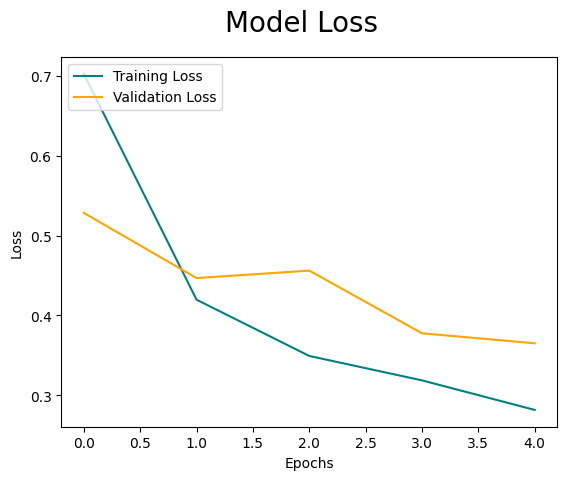

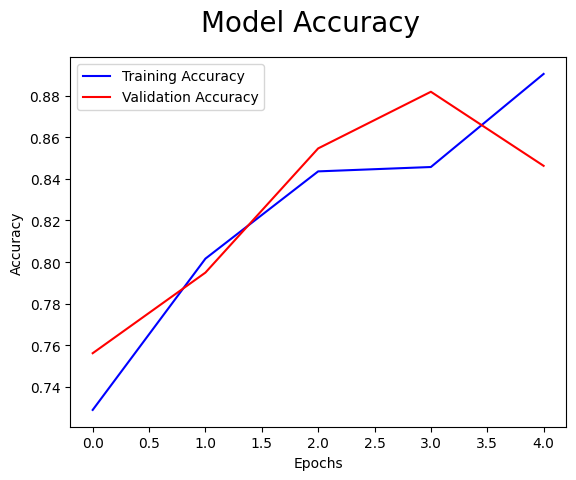

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8095 - loss: 0.3680
Test Loss: 0.33702352643013
Test Accuracy: 0.8214285969734192


In [64]:
import matplotlib.pyplot as plt

# Plot training and validation loss
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Model Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

# Plot training and validation accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='Validation Accuracy')
fig.suptitle('Model Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


<h3>10. Test Model</h3>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


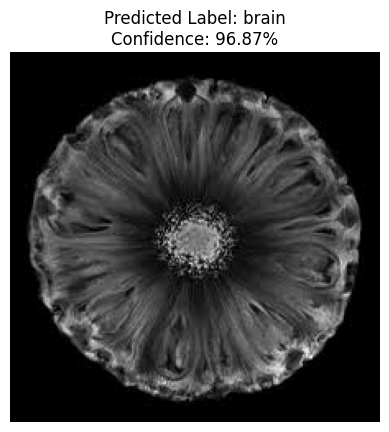

In [98]:


# Define the remapping for labels
label_map = {
    0: 1,  # Map heart to brain
    1: 0,  # Map brain to heart
    2: 3,  # Map limbs to liver
    3: 2   # Map liver to limbs
}

# Load and preprocess the image
def preprocess_image(image_path, img_size=(256, 256)):
    img = load_img(image_path, target_size=img_size)   # Load the image with target size
    img_array = img_to_array(img)                      # Convert image to array
    img_array = img_array / 255.0                      # Normalize to [0, 1] range
    img_array = np.expand_dims(img_array, axis=0)      # Add batch dimension
    return img_array

# Predict and display results
def test_model(image_path):
    img_array = preprocess_image(image_path)            # Preprocess the image
    prediction = model.predict(img_array)               # Predict class
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the class with highest probability

    # Get the confidence of the prediction
    confidence = np.max(prediction)*100  # Get the highest confidence score

    # Apply the label mapping
    remapped_class = label_map.get(predicted_class, predicted_class)

    # Display the image and prediction
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Label: {organ_names[remapped_class]}\nConfidence: {confidence:.2f}%')
    plt.show()


# Test the model with an example image
test_image_path = "test_data/NONE/d2.jpeg"              # Path to an example test image
test_model(test_image_path)


<h3>11. Save Model</h3>

In [77]:


# Define the path for saving the model
save_dir = 'save_model'
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

# Save the model to the 'save_model' directory as 'organsClssify.h5'
model.save(os.path.join(save_dir, 'organsClssify.h5'))

# Load the model using the full path to the file
new_model_path = os.path.join(save_dir, 'organsClssify.h5')
new_model = load_model(new_model_path)